In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

In [2]:
# Test on Lunar Lander to check functionality of agent
#env = gym.make('LunarLander-v2')
#n_actions= env.action_space.n

In [2]:
max_steps = 30000000
replay_memory_size = 60000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 20000
eps_annealing_steps = 10000000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.0000000625
#batch_size = 512
#learning_rate = 0.001

In [3]:
env = RLTe.RLtractEnvironment(stepWidth=0.1, action_space=20, maxL2dist_to_State=0.1, device = 'cpu')
#env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307


In [5]:
state = env.reset()
#print(state.getValue().flatten().shape)

In [19]:
print(env.directions)

[[-0.23652158  0.89251771  0.38401782]
 [-0.11767427 -0.09967872 -0.9880369 ]
 [ 0.47731431  0.57325226 -0.66599767]
 [-0.249248    0.91915546 -0.30500604]
 [-0.31432637  0.35044225  0.88226366]
 [-0.45287205  0.12827628  0.88229933]
 [ 0.03978093 -0.17704997  0.98339757]
 [ 0.12691877  0.38790863 -0.91291759]
 [-0.94617132 -0.08484967 -0.31234656]
 [-0.663741   -0.43548651 -0.60811132]
 [ 0.06189021  0.01859403  0.99790975]
 [-0.07364839 -0.05903757 -0.99553527]
 [ 0.24059212  0.44106988 -0.86462292]
 [ 0.56773229  0.24589824  0.78562975]
 [ 0.51301452 -0.17066922  0.84124201]
 [ 0.53217315 -0.1167378   0.83854876]
 [ 0.29301394 -0.76241069  0.57695128]
 [-0.33543656  0.93885335 -0.07769624]
 [ 0.79891353  0.56277753  0.21217591]
 [ 0.          0.          0.        ]]


In [15]:
# Debugging the optimization of the agent

#state = env.reset()
#state = torch.tensor([state]).to(device).float()
transition = init_transition()
state = torch.FloatTensor([np.array(transition)]).to(device)
print(state.shape)
print(agent.main_dqn(state))
print(agent.target_dqn(state))

action = 1

next_state, reward, done = env.step(action)
print(next_state, reward, done)

action = torch.tensor([action]).to(device)
#next_state = torch.tensor([next_state]).float().to(device)
next_state = add_to_transition(next_state, transition)
next_state = torch.FloatTensor([np.array(next_state)]).to(device)
reward = torch.tensor([reward]).float().to(device)
done = torch.BoolTensor([done]).to(device)
state_action_values = agent.main_dqn(state)
print(state_action_values)
state_action_values = state_action_values[0][action]
print(state_action_values)

next_state_actions = agent.main_dqn(next_state).max(1)[1]
print("Argmax actions: ", next_state_actions)
next_state_values = agent.target_dqn(next_state)[0][next_state_actions]
print(next_state_values)
next_state_values[done] = 0.0
print(next_state_values)
expected_state_action_values = next_state_values.detach() * 0.99 + reward
print(expected_state_action_values)

agent.optimizer.zero_grad()
loss = torch.nn.SmoothL1Loss()(state_action_values, expected_state_action_values)
print(loss)
loss.backward()
agent.optimizer.step()

print(agent.main_dqn(state))
print(agent.target_dqn(state))

torch.Size([1, 12])
tensor([[ 61.8814,  53.5273,  65.1122,  59.5295,  63.2473,  63.3582,  49.6618,
          57.5226,  56.9831,  61.0424,  49.2360,  45.0796,  60.3465,  55.7477,
          60.6391,  54.9909,  55.8694,  60.2220,  35.0820,  47.0737,  53.0218,
          56.9755,  60.0529,  32.3047,  20.4098,  58.4533,  59.7584,  63.0841,
          54.4836,  43.6310,  57.3373,  22.6192,  32.9992,  61.3936,  32.4899,
          60.6012,   8.0376,  39.1546,  58.7364,  28.7151,  25.3395,  59.5876,
          13.1139,  54.3735,  25.8479,  10.7677,  54.2027,  11.2558,  38.6437,
          60.1825,  22.2333,  24.1235,   8.7726,  27.5614,   2.9120,  12.3545,
          26.7937,  17.6043,  34.9672, -12.4343,  23.0219,  27.1385, -15.7887,
          61.7124,  42.1585,  20.3453,  24.3167,  -4.8190,  43.8532,  45.2633,
          13.3825,  64.5126,   0.7540,  17.9066,  45.4248,  -8.3953,  60.9557,
          51.1121,  22.9783,  49.9606,   8.7290,   3.0979,  55.1753,  -3.8223,
          64.8611,  28.4904,  43

In [4]:
state = env.reset(streamline_index=0)
#env.stepCounter += 1
#state = env.state = TractographyState(env.referenceStreamline_ijk[1], env.interpolateDWIatState)
best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
rewards = []
all_states = []
all_states.append(state.getCoordinate())
for i in range(n_actions):
    #print(state.getCoordinate(), env.state.getCoordinate())
    #print(env.stepCounter)
    next_state, reward,_ = env.step(i)
    all_states.append(next_state.getCoordinate())
    all_states.append(state.getCoordinate())
    rewards.append(reward)
    #print(reward)
    best_actions.append(reward)
    env.state = state
    env.stepCounter -= 1
best_action= torch.argmax(torch.tensor(best_actions))
#return best_action, rewards[best_action]
print(best_action, float(rewards[best_action]))
#print(np.argmin(rewards))


tensor(8) 0.946156463865072


In [7]:
#cos = torch.nn.CosineSimilarity(dim=0)

def get_best_action(state, env):
    best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
    rewards = []
    points_before = env.points_visited
    for i in range(n_actions):
        #print(state.getCoordinate(), env.state.getCoordinate())
        #print("Step counter: ", env.stepCounter)
        next_state, reward,_, _ = env.step(i)
        #print("Point counter: ", env.points_visited)
        env.stepCounter -= 1
        if env.points_visited > points_before:
            env.points_visited = points_before
        #print("Action: {}, Distance: {}".format(i, env.l2_distance))
        #print("Step counter: ", env.stepCounter)
        #print("Point counter: ", env.points_visited)
        #current_index = np.min([env.points_visited,len(env.referenceStreamline_ijk)-1])
        #print("Current reference index: ", current_index)
        #path_vector = next_state.getCoordinate() - state.getCoordinate().squeeze(0)
        #print(path_vector)
        #path_vectors.append(path_vector.numpy())
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #print(reference_vector)
        #reference_vectors.append(reference_vector.numpy())
        #cosine_sim = cos(path_vector, reference_vector)
        #cosine_sims.append(cosine_sim.item())
        #print(cosine_sim)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
        #dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        #reward = -dist
        #if dist < 0.1:
        #    dist = 0
        #else:
        #    dist = dist - 0.1
        
        #distances.append(dist.item())

        #reward = cosine_sim - dist
        #reward = cosine_sim
        rewards.append(env.l2_distance)
        #print(reward)
        best_actions.append(-env.l2_distance)
        env.state = state

    #best_actions = torch.topk(torch.tensor(best_actions), k=1)[1].numpy()
    #rewards = np.array(rewards)
    #print(rewards)
    #random_action = np.random.choice(best_actions, size=1)
    best_action= torch.argmax(torch.tensor(best_actions))
    return best_action, rewards[best_action]#random_action
    #return best_actions, rewards[best_actions]

In [4]:
def get_best_action(state, env):
    distances = []
    points_before = env.points_visited
    for i in range(n_actions):
        next_state, reward,_, _ = env.step(i)
        env.stepCounter -= 1
        if env.points_visited > points_before:
            env.points_visited = points_before
        del env.state_history[-1]
        distances.append(env.l2_distance)
        env.state = state
        

    best_action= np.argmin(distances)
    return best_action, distances[best_action]

In [3]:
state = env.reset(streamline_index=4)
state, _, _, _ = env.step(5)
state, _, _, _ = env.step(5)
state, _, _, _ = env.step(5)
state, _, _, _ = env.step(5)
state, _, _, _ = env.step(8)
state, _, _, _ = env.step(5)
state, _, _, _ = env.step(5)

print(env.stepCounter, env.points_visited)
best_action, best_reward = get_best_action(state, env)

print(best_action)

NameError: name 'env' is not defined

In [5]:
state = env.reset(streamline_index=4)
all_top_actions = []
all_top_rewards = []
terminal = False
all_states = []
while terminal != True:
    all_states.append(state.getCoordinate())
    best_action, distance = get_best_action(state, env)
    all_top_actions.append(best_action)
    next_state, reward, terminal, _ = env.step(best_action)
    #if best_dist < 1.2:
    #    reward = 1.
    #    env.points_visited += 1
    all_top_rewards.append(reward)
    #print("Action: {}, Distance: {}".format(best_action, best_distance))
    if reward == 1:
        print("Reached point {}/{} at epsiode step {}".format(env.points_visited, len(env.referenceStreamline_ijk), env.stepCounter))
    state = next_state
    
for i in range(len(all_top_actions)):
    print(all_top_actions[i], all_top_rewards[i])
print(len(all_top_actions))

Reached point 2/43 at epsiode step 10
Reached point 3/43 at epsiode step 20
Reached point 4/43 at epsiode step 30
Reached point 5/43 at epsiode step 41
Reached point 6/43 at epsiode step 52
Reached point 7/43 at epsiode step 62
Reached point 8/43 at epsiode step 71
Reached point 9/43 at epsiode step 79
Reached point 10/43 at epsiode step 88
Reached point 11/43 at epsiode step 97
Reached point 12/43 at epsiode step 106
Reached point 13/43 at epsiode step 116
Reached point 14/43 at epsiode step 125
Reached point 15/43 at epsiode step 134
Reached point 16/43 at epsiode step 143
Reached point 17/43 at epsiode step 152
Reached point 18/43 at epsiode step 161
Reached point 19/43 at epsiode step 170
Reached point 20/43 at epsiode step 179
Reached point 21/43 at epsiode step 188
Reached point 22/43 at epsiode step 197
Reached point 23/43 at epsiode step 207
Reached point 24/43 at epsiode step 217
Reached point 25/43 at epsiode step 227
Reached point 26/43 at epsiode step 237
Reached point 27/4

In [34]:
best_action, distance = get_best_action(state, env)
print(best_action)
next_state, reward, terminal, _ = env.step(best_action)
all_states.append(next_state.getCoordinate())

Action: 0, Distance: 0.675200144025479
Action: 1, Distance: 0.8193549932590946
Action: 2, Distance: 0.7624390000541466
Action: 3, Distance: 0.7612164998466645
Action: 4, Distance: 0.8153076118507011
Action: 5, Distance: 0.8301482197716156
Action: 6, Distance: 0.8475821631536381
Action: 7, Distance: 0.7968080730412787
Action: 8, Distance: 0.7858430546118226
Action: 9, Distance: 0.7640558841291659
Action: 10, Distance: 0.8291077436903749
Action: 11, Distance: 0.82494145774529
Action: 12, Distance: 0.7865671446070094
Action: 13, Distance: 0.7863385496018339
Action: 14, Distance: 0.8273356128555844
Action: 15, Distance: 0.8216121503275755
Action: 16, Distance: 0.779188045221242
Action: 17, Distance: 0.7626969439293073
Action: 18, Distance: 0.7460997923733453
Action: 19, Distance: 0.8297638038322916
0


In [109]:
print(state.getCoordinate(), env.referenceStreamline_ijk[-1])
state, _, _, _ = env.step(8)
best_action, best_reward = get_best_action(state, env)

print(best_action)

tensor([82.4722, 35.6822, 79.8644], dtype=torch.float64) tensor([82.3763, 35.7140, 79.7998])
Defi stopped at/close to the terminal state!
tensor(18)


In [20]:
state = env.reset(streamline_index=0)
state, _, _, _ = env.step(11)
print(env.l2_distance)

tensor(0.9062, dtype=torch.float64)


In [97]:
print(env.stepCounter)
print(env.points_visited, len(env.referenceStreamline_ijk)-1)
print(np.min([env.points_visited,len(env.referenceStreamline_ijk)-1]))

541
113 86
86


In [ ]:
### Transfer learning

In [85]:
#### Fill replay memory with perfect actions for supervised approach

from tqdm import trange
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
for overall_runs in trange(5):
    state = env.reset(streamline_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        action, _ = get_best_action(state,env)
        next_state, reward, terminal, _ = env.step(action)
        
        #terminal = False

        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        #cosine_sim = cos(path_vector, reference_vector)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
        #if dist > 3*0.81:
        #    env.stepCounter -= 1
        #if dist < 0.1:
        #    dist = 0
        #else:
        #    dist = dist - 0.1
        #reward = cosine_sim - dist
        #reward_old = 1 - (optimal_reward - reward)
        #print(env.stepCounter, next_state.getCoordinate().numpy(), reward, reward_old, terminal)
        #if action == 100 and dist==0:
        #    terminal = True

        #if env.stepCounter == 200:
        #    terminal = True
        #dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        
        #reward = 0.
            #positive_run += 1 
        #if dist > 2.:
        #    reward = -1.
        #    #print("Got negative reward at step ", i)

        #if dist > 0.25:
        #    env.stepCounter -= 1
        #    #if dist < dist_past:
        #    #    reward = 0.5
        #else:
        #    #print("Reached referencePoint at step", i)
        #    reward = 1.
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

 20%|██        | 1/5 [01:43<06:53, 103.34s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
1 86.0


 40%|████      | 2/5 [02:48<04:35, 91.79s/it] 

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
2 71.5


 60%|██████    | 3/5 [05:40<03:51, 115.86s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
3 98.33333333333333


 80%|████████  | 4/5 [07:01<01:45, 105.62s/it]

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
4 91.25


100%|██████████| 5/5 [07:51<00:00, 94.30s/it] 

Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
Defi reached the terminal state!
5 81.4
Replay memory ready


In [87]:
print(agent.replay_memory.count)

3740


In [14]:
#save memory
import h5py
hf = h5py.File('memory.hdf5', 'w')
hf.create_dataset('states', data=agent.replay_memory.states[:agent.replay_memory.count])
hf.create_dataset('new_states', data=agent.replay_memory.new_states[:agent.replay_memory.count])
hf.create_dataset('actions', data=agent.replay_memory.actions[:agent.replay_memory.count])
hf.create_dataset('rewards', data=agent.replay_memory.rewards[:agent.replay_memory.count])
hf.create_dataset('terminals', data=agent.replay_memory.terminal_flags[:agent.replay_memory.count])
hf.close()


In [3]:
#load memory
#state = #env.reset().getValue()
agent_learn = Agent(n_actions=20, inp_size=(642, 3, 3, 3), device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
hf = h5py.File('memory.hdf5', 'r')
agent_learn.replay_memory.states = np.array(hf["states"][:60000])
agent_learn.replay_memory.new_states = np.array(hf["new_states"][:60000])
agent_learn.replay_memory.actions = np.array(hf["actions"][:60000])
agent_learn.replay_memory.rewards = np.array(hf["rewards"][:60000])
agent_learn.replay_memory.terminal_flags = np.array(hf["terminals"][:60000])
hf.close()

In [ ]:
print(agent_learn.replay_memory.states.shape)

In [6]:
agent_learn.replay_memory.count = 60000

In [4]:
agent_learn = Agent(n_actions=101, inp_size=(100, 3, 3, 3), device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
hf = h5py.File('memory.hdf5', 'r')
agent_learn.replay_memory.states = np.array(hf["states"][:])
agent_learn.replay_memory.new_states = np.array(hf["next_states"][:])
agent_learn.replay_memory.actions = np.array(hf["actions"][:])
agent_learn.replay_memory.rewards = np.array(hf["rewards"][:])
agent_learn.replay_memory.terminal_flags = np.array(hf["terminal_flags"][:])
print(agent_learn.replay_memory.states.shape)

(30000, 100, 3, 3, 3)


In [5]:
agent_learn.replay_memory.count = 30000

In [79]:
agent.optimizer = torch.optim.Adam(agent.main_dqn.parameters(), 0.00001)

In [ ]:
##### DQN algorithm on perfect memory  ---> failure

#for i in range(200):
#state = env.reset().getValue()
#agent_learn = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
#agent_learn.replay_memory.count = 300000
#agent_learn.replay_memory.current = 300000
losses_q = []

for i in trange(200000):
    
    states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    next_states = torch.FloatTensor(new_states).to(agent.device)
    rewards = torch.FloatTensor(rewards).to(agent.device)
    terminal_flags = torch.BoolTensor(terminal_flags).to(agent.device)

    arg_q_max = torch.argmax(agent.main_dqn(next_states), dim=1).detach()
    #print(arg_q_max.shape)
    q_vals = agent_learn.target_dqn(next_states).detach()
    #print(q_vals.shape)
    double_q = q_vals[range(agent_learn.batch_size), arg_q_max].detach()

    target_q = rewards + (agent_learn.gamma * double_q * ~terminal_flags).detach()

    current_qs = agent_learn.main_dqn(states)
    #print(current_qs)
    #print(current_qs)
    #print(actions)
    predict_q = torch.sum(torch.mul(current_qs, torch.nn.functional.one_hot(actions)), dim=1)
    #print(predict_q)
    #print(predict_q)
    #print(predict_q.shape)

    loss = torch.nn.functional.smooth_l1_loss(predict_q, target_q)
    losses_q.append(loss.item())
    agent_learn.optimizer.zero_grad()
    loss.backward()
    agent_learn.optimizer.step()
    #if i % 20 == 0:
    #    print(i, loss.item())
    
    if i % 10000 == 0:
        #print("Target update")
        agent_learn.target_dqn.load_state_dict(agent_learn.main_dqn.state_dict())



In [88]:
#### Supervised learning on perfect memory --> worked

#state = env.reset().getValue()
#agent_learn = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=64, learning_rate=0.00001)

agent.optimizer = torch.optim.Adam(agent.main_dqn.parameters(), 0.0001) # optional --> change optimizer and/or lr
losses = []
for i in trange(70000):
    states, actions, _, _, _ = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    actions = torch.LongTensor(actions).to(agent.device)
    predicted_q = agent.main_dqn(states)
    loss = torch.nn.functional.cross_entropy(predicted_q, actions)
    #print(loss.item())
    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    losses.append(loss.item())

100%|██████████| 70000/70000 [09:14<00:00, 126.21it/s]


In [89]:
mean_losses = []
for i in range(len(losses)):
    mean_losses.append(np.mean(losses[i:i+99]))
#print(mean_losses[-20:])

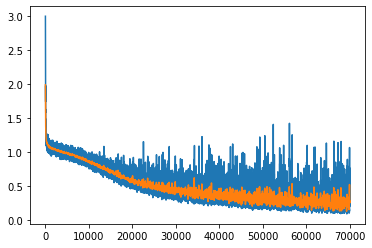

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(losses[:])), losses[:])
ax.plot(range(len(losses[:])), mean_losses[:])
plt.show()

In [66]:
agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

<All keys matched successfully>

In [124]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

Accuracy = 0.884765625


In [148]:
#### test performance of pretrained agent

state = env.reset(streamline_index=2)
terminal = False
all_states = []
all_states.append(state.getCoordinate())

episode_reward = 0

agent.main_dqn.eval()
while not terminal:
    action = torch.argmax(agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
    next_state, reward, terminal, _ = env.step(action)
    #if reward < 0.:
    #
    if reward == 0. and env.l2_distance < 0.17:
        reward = 1.
        env.points_visited += 1
    print("Reward {} at step {}, points reached {}, l2 distance {}".format(reward, env.stepCounter, env.points_visited, env.l2_distance))
    
    episode_reward += reward
    all_states.append(next_state.getCoordinate())
    state = next_state
    
print("Episode finished with {} reward".format(episode_reward))

Reward 0.0 at step 1, points reached 1, l2 distance 0.7041031727801926
Reward 0.0 at step 2, points reached 1, l2 distance 0.6095272143920613
Reward 0.0 at step 3, points reached 1, l2 distance 0.5169966849506465
Reward 0.0 at step 4, points reached 1, l2 distance 0.4278407640879614
Reward 0.0 at step 5, points reached 1, l2 distance 0.3430604553658933
Reward 0.0 at step 6, points reached 1, l2 distance 0.26062626168711084
Reward 0.0 at step 7, points reached 1, l2 distance 0.18057313322995786
Reward 1.0 at step 8, points reached 2, l2 distance 0.09257038388796034
Reward 0.0 at step 9, points reached 2, l2 distance 0.7989205645834965
Reward 0.0 at step 10, points reached 2, l2 distance 0.7088313262862007
Reward 0.0 at step 11, points reached 2, l2 distance 0.6200152902489539
Reward 0.0 at step 12, points reached 2, l2 distance 0.5347707845592775
Reward 0.0 at step 13, points reached 2, l2 distance 0.45315555199224283
Reward 0.0 at step 14, points reached 2, l2 distance 0.36896200321033

Reward 0.0 at step 122, points reached 14, l2 distance 0.8319902898091356
Reward 0.0 at step 123, points reached 14, l2 distance 0.7469655416843685
Reward 0.0 at step 124, points reached 14, l2 distance 0.6621941494663587
Reward 0.0 at step 125, points reached 14, l2 distance 0.5802337026319369
Reward 0.0 at step 126, points reached 14, l2 distance 0.4962294462410773
Reward 0.0 at step 127, points reached 14, l2 distance 0.41341948814237356
Reward 0.0 at step 128, points reached 14, l2 distance 0.3286334914647462
Reward 0.0 at step 129, points reached 14, l2 distance 0.24778079198899894
Reward 1.0 at step 130, points reached 15, l2 distance 0.16379665871414797
Reward 0.0 at step 131, points reached 15, l2 distance 0.8762233330556992
Reward 0.0 at step 132, points reached 15, l2 distance 0.7913008777044448
Reward 0.0 at step 133, points reached 15, l2 distance 0.7070358220112197
Reward 0.0 at step 134, points reached 15, l2 distance 0.6245730082526753
Reward 0.0 at step 135, points reac

Reward 0.0 at step 242, points reached 27, l2 distance 0.5432053103783362
Reward 0.0 at step 243, points reached 27, l2 distance 0.44702633930046265
Reward 0.0 at step 244, points reached 27, l2 distance 0.3477807819000415
Reward 0.0 at step 245, points reached 27, l2 distance 0.2548329552595219
Reward 0.0 at step 246, points reached 27, l2 distance 0.18959178833611268
Reward 1.0 at step 247, points reached 28, l2 distance 0.12505487893398018
Reward 0.0 at step 248, points reached 28, l2 distance 0.7428229699132135
Reward 0.0 at step 249, points reached 28, l2 distance 0.6480519651024359
Reward 0.0 at step 250, points reached 28, l2 distance 0.555249622649779
Reward 0.0 at step 251, points reached 28, l2 distance 0.4606439427677022
Reward 0.0 at step 252, points reached 28, l2 distance 0.3690920612822458
Reward 0.0 at step 253, points reached 28, l2 distance 0.2753633272075993
Reward 0.0 at step 254, points reached 28, l2 distance 0.18859051772889387
Reward 1.0 at step 255, points reac

Reward 1.0 at step 361, points reached 42, l2 distance 0.16277231320477173
Reward 0.0 at step 362, points reached 42, l2 distance 0.849229631244526
Reward 0.0 at step 363, points reached 42, l2 distance 0.7497031133995878
Reward 0.0 at step 364, points reached 42, l2 distance 0.6503218817619142
Reward 0.0 at step 365, points reached 42, l2 distance 0.5511645322003936
Reward 0.0 at step 366, points reached 42, l2 distance 0.45237830762869297
Reward 0.0 at step 367, points reached 42, l2 distance 0.3542737992998097
Reward 0.0 at step 368, points reached 42, l2 distance 0.25763096965940113
Reward 1.0 at step 369, points reached 43, l2 distance 0.1650378992382192
Reward 0.0 at step 370, points reached 43, l2 distance 0.8994834655932281
Reward 0.0 at step 371, points reached 43, l2 distance 0.8028121118162571
Reward 0.0 at step 372, points reached 43, l2 distance 0.7070672308077591
Reward 0.0 at step 373, points reached 43, l2 distance 0.6126833202278541
Reward 0.0 at step 374, points reach

Reward -1.0 at step 483, points reached 43, l2 distance 8.984433428813048
Reward -1.0 at step 484, points reached 43, l2 distance 9.073736080928168
Reward -1.0 at step 485, points reached 43, l2 distance 9.155580578505806
Reward -1.0 at step 486, points reached 43, l2 distance 9.221442254602614
Reward -1.0 at step 487, points reached 43, l2 distance 9.310872434319434
Reward -1.0 at step 488, points reached 43, l2 distance 9.400060287364996
Reward -1.0 at step 489, points reached 43, l2 distance 9.482154299942094
Reward -1.0 at step 490, points reached 43, l2 distance 9.577646901190576
Reward -1.0 at step 491, points reached 43, l2 distance 9.667330018917339
Reward -1.0 at step 492, points reached 43, l2 distance 9.756284007516118
Reward -1.0 at step 493, points reached 43, l2 distance 9.838622087728671
Reward -1.0 at step 494, points reached 43, l2 distance 9.927532545785576
Reward -1.0 at step 495, points reached 43, l2 distance 10.009941024766054
Reward -1.0 at step 496, points reach

Reward -1.0 at step 605, points reached 43, l2 distance 18.976515954969575
Reward -1.0 at step 606, points reached 43, l2 distance 19.040228927145108
Reward -1.0 at step 607, points reached 43, l2 distance 19.10425286178373
Reward -1.0 at step 608, points reached 43, l2 distance 19.16858464299987
Reward -1.0 at step 609, points reached 43, l2 distance 19.23322118171392
Reward -1.0 at step 610, points reached 43, l2 distance 19.32681117415662
Reward -1.0 at step 611, points reached 43, l2 distance 19.391876857892164
Reward -1.0 at step 612, points reached 43, l2 distance 19.457238909511346
Reward -1.0 at step 613, points reached 43, l2 distance 19.551142557945777
Reward -1.0 at step 614, points reached 43, l2 distance 19.616919516900126
Reward -1.0 at step 615, points reached 43, l2 distance 19.71100349482804
Reward -1.0 at step 616, points reached 43, l2 distance 19.77718667773078
Reward -1.0 at step 617, points reached 43, l2 distance 19.871445302938287
Reward -1.0 at step 618, points

Reward -1.0 at step 728, points reached 43, l2 distance 26.164058810906685
Reward -1.0 at step 729, points reached 43, l2 distance 26.171636269316824
Reward -1.0 at step 730, points reached 43, l2 distance 26.179593514152508
Reward -1.0 at step 731, points reached 43, l2 distance 26.18793019921758
Reward -1.0 at step 732, points reached 43, l2 distance 26.210893535336815
Reward -1.0 at step 733, points reached 43, l2 distance 26.261514601317757
Reward -1.0 at step 734, points reached 43, l2 distance 26.340386448773685
Reward -1.0 at step 735, points reached 43, l2 distance 26.349845404342638
Reward -1.0 at step 736, points reached 43, l2 distance 26.35968033559537
Reward -1.0 at step 737, points reached 43, l2 distance 26.369890821859496
Reward -1.0 at step 738, points reached 43, l2 distance 26.380476427062614
Reward -1.0 at step 739, points reached 43, l2 distance 26.405576431180755
Reward -1.0 at step 740, points reached 43, l2 distance 26.458008980585728
Reward -1.0 at step 741, po

Reward -1.0 at step 852, points reached 43, l2 distance 31.348326510164508
Reward -1.0 at step 853, points reached 43, l2 distance 31.40373423115105
Reward -1.0 at step 854, points reached 43, l2 distance 31.459362236600622
Reward -1.0 at step 855, points reached 43, l2 distance 31.515209360030255
Reward -1.0 at step 856, points reached 43, l2 distance 31.57127443863209
Reward -1.0 at step 857, points reached 43, l2 distance 31.607196793094502
Reward -1.0 at step 858, points reached 43, l2 distance 31.663607804901577
Reward -1.0 at step 859, points reached 43, l2 distance 31.69993375533991
Reward -1.0 at step 860, points reached 43, l2 distance 31.73653322219132
Reward -1.0 at step 861, points reached 43, l2 distance 31.814354141047485
Reward -1.0 at step 862, points reached 43, l2 distance 31.851350036136957
Reward -1.0 at step 863, points reached 43, l2 distance 31.92941772747313
Reward -1.0 at step 864, points reached 43, l2 distance 31.966806455606946
Reward -1.0 at step 865, point

Reward -1.0 at step 975, points reached 43, l2 distance 37.73968822373385
Reward -1.0 at step 976, points reached 43, l2 distance 37.71048543008464
Reward -1.0 at step 977, points reached 43, l2 distance 37.78034394664906
Reward -1.0 at step 978, points reached 43, l2 distance 37.75150462730245
Reward -1.0 at step 979, points reached 43, l2 distance 37.82161878780258
Reward -1.0 at step 980, points reached 43, l2 distance 37.79314262373721
Reward -1.0 at step 981, points reached 43, l2 distance 37.8635107225005
Reward -1.0 at step 982, points reached 43, l2 distance 37.83539737641641
Reward -1.0 at step 983, points reached 43, l2 distance 37.906017704795254
Reward -1.0 at step 984, points reached 43, l2 distance 37.97677002907389
Reward -1.0 at step 985, points reached 43, l2 distance 37.949137667935
Reward -1.0 at step 986, points reached 43, l2 distance 38.020139427610495
Reward -1.0 at step 987, points reached 43, l2 distance 37.99286852481405
Reward -1.0 at step 988, points reached

Reward -1.0 at step 1098, points reached 43, l2 distance 42.27141937884359
Reward -1.0 at step 1099, points reached 43, l2 distance 42.35423016336715
Reward -1.0 at step 1100, points reached 43, l2 distance 42.38277843888682
Reward -1.0 at step 1101, points reached 43, l2 distance 42.37246801452969
Reward -1.0 at step 1102, points reached 43, l2 distance 42.45555646282203
Reward -1.0 at step 1103, points reached 43, l2 distance 42.48454436546412
Reward -1.0 at step 1104, points reached 43, l2 distance 42.47464670003461
Reward -1.0 at step 1105, points reached 43, l2 distance 42.50394974381716
Reward -1.0 at step 1106, points reached 43, l2 distance 42.49438483300543
Reward -1.0 at step 1107, points reached 43, l2 distance 42.57794729966832
Reward -1.0 at step 1108, points reached 43, l2 distance 42.56869346731357
Reward -1.0 at step 1109, points reached 43, l2 distance 42.65240422510813
Reward -1.0 at step 1110, points reached 43, l2 distance 42.64346048567048
Reward -1.0 at step 1111,

Reward -1.0 at step 1222, points reached 43, l2 distance 47.4616201107053
Reward -1.0 at step 1223, points reached 43, l2 distance 47.54963992997602
Reward -1.0 at step 1224, points reached 43, l2 distance 47.5580061408197
Reward -1.0 at step 1225, points reached 43, l2 distance 47.636071325580254
Reward -1.0 at step 1226, points reached 43, l2 distance 47.72416008119697
Reward -1.0 at step 1227, points reached 43, l2 distance 47.7328761712467
Reward -1.0 at step 1228, points reached 43, l2 distance 47.81111047665876
Reward -1.0 at step 1229, points reached 43, l2 distance 47.889425789447166
Reward -1.0 at step 1230, points reached 43, l2 distance 47.97756536317499
Reward -1.0 at step 1231, points reached 43, l2 distance 48.05594465871794
Reward -1.0 at step 1232, points reached 43, l2 distance 48.144114014164366
Reward -1.0 at step 1233, points reached 43, l2 distance 48.153417553632856
Reward -1.0 at step 1234, points reached 43, l2 distance 48.24166858652133
Reward -1.0 at step 1235

Reward -1.0 at step 1345, points reached 43, l2 distance 56.966180798535206
Reward -1.0 at step 1346, points reached 43, l2 distance 57.05017009375736
Reward -1.0 at step 1347, points reached 43, l2 distance 57.13421094827418
Reward -1.0 at step 1348, points reached 43, l2 distance 57.218303134898534
Reward -1.0 at step 1349, points reached 43, l2 distance 57.30244642763854
Reward -1.0 at step 1350, points reached 43, l2 distance 57.393550481162755
Reward -1.0 at step 1351, points reached 43, l2 distance 57.477775358597256
Reward -1.0 at step 1352, points reached 43, l2 distance 57.56205072365789
Reward -1.0 at step 1353, points reached 43, l2 distance 57.65324530781463
Reward -1.0 at step 1354, points reached 43, l2 distance 57.74446904711425
Reward -1.0 at step 1355, points reached 43, l2 distance 57.83572180359835
Reward -1.0 at step 1356, points reached 43, l2 distance 57.927003440134094
Reward -1.0 at step 1357, points reached 43, l2 distance 58.01144914954536
Reward -1.0 at step 

<IPython.core.display.Javascript object>


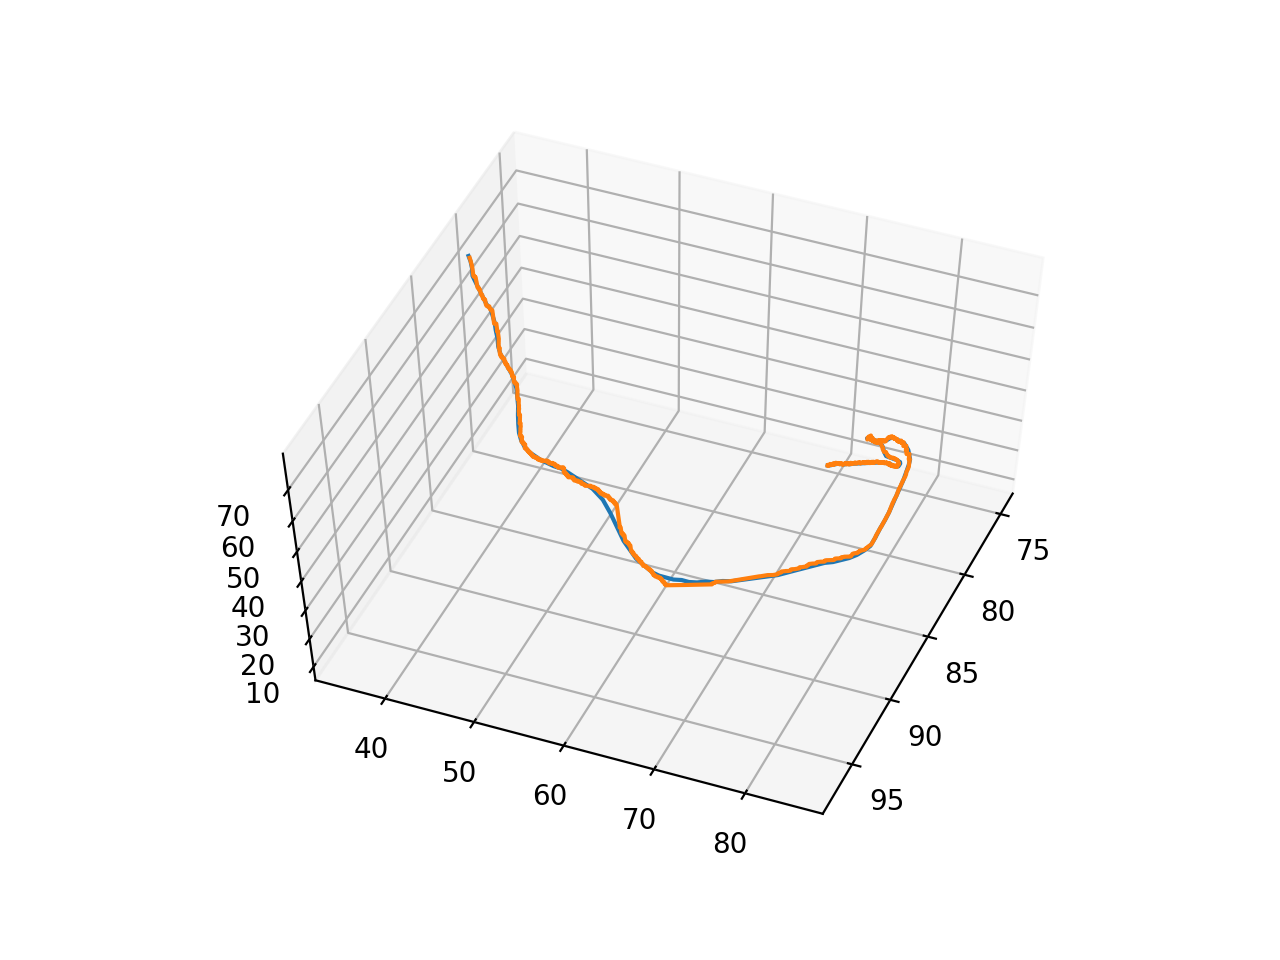

In [147]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])

In [6]:
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

In [79]:
agent.main_dqn.load_state_dict(torch.load("defi_pretrained_95pacc.pth"))
#agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

RuntimeError: Error(s) in loading state_dict for DQN:
	size mismatch for linear_layers.0.weight: copying a param with shape torch.Size([1024, 17334]) from checkpoint, the shape in current model is torch.Size([1024, 2700]).

In [10]:
print(state.shape)
print(agent.main_dqn)

(642, 3, 3, 3)
DQN(
  (linear_layers): ModuleList(
    (0): Linear(in_features=17334, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): Linear(in_features=1024, out_features=20, bias=True)
  )
)


In [ ]:
#### DQN training

#uncomment next 2 lines for regular DQN trainig without pretrained network
#state = env.reset().getValue()
#agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

#transition = init_transition()
#agent = Agent(n_actions=n_actions, inp_size=np.array(transition).shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_initial=0.5, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=agent.main_dqn)

step_counter = 0

eps_rewards = []

episode_lengths = []

cos = torch.nn.CosineSimilarity(dim=0)

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    #agent.main_dqn.train()
######## fill memory begins here
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        env.stepCounter = np.random.randint(len(env.referenceStreamline_ijk)-10)
        env.state = TractographyState(env.referenceStreamline_ijk[env.stepCounter], env.interpolateDWIatState)
        #transition = init_transition()
        #referenceLine = env.referenceStreamline_ijk
        episode_reward_sum = 0
        terminal = False
        #fill replay memory while interacting with env
        #for episode_counter in range(max_episode_length):
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        dist = 0
        #influential_action = None
        while not terminal:
            # get action with epsilon-greedy strategy
            #if dist < 0.1:
            #_, optimal_reward = get_best_action(state, env)
               #print(influential_action)
            #else:
            #    influential_action = None
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)) #influential_action=influential_action)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device))
            #print("Before step: ", env.stepCounter)
            
            next_state, reward, terminal = env.step(action)
            episode_step_counter += 1
            #print(episode_step_counter, action, reward, optimal_reward, torch.tanh(1-(optimal_reward - reward)))
            #print("After step: ", env.stepCounter)
            
            #if reward < -1.:
            #    reward = -1.
            
            #terminal = False
            
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            ##    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #reward = -torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            #if reward == 0.:
            #    reward = 1.
            
            #if reward < -0.05:
            #    env.stepCounter -= 1
            
            #reward = torch.tanh(1- (optimal_reward - reward))
            #if reward >= 0.76:
            #    reward = 1.
            #elif reward < 0.:
            #    reward = -1.
            #else:
            #    reward = 0.
            current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
            #if dist <= 0.09:
            #    reward = 1.
            #elif dist < 0.25:
            #    reward = 0.5
            #elif dist < 1.:
            #    reward = 0.25
            #elif dist_past < dist:
            #    reward = -1
            #    #env.stepCounter -= 1
            #else:
            #    reward = 0.
                #env.stepCounter -= 1
            
            #if action == 19:
            #    if dist <= 0.09:
            #        reward = 1.
            #    else:
            #        reward = -1.
                    
            #if reward > 0.:
            #    positive_run += 1
            #print("Before test for dist: ", env.stepCounter, "Dist: ", dist)
            #print("After test for dist: ", env.stepCounter)
            #if dist < dist_past:
            reward = 0.
                #positive_run += 1 
            if dist > 2.:
                reward = -1.
                
            if dist > 0.25:
                env.stepCounter -= 1
                #if dist < dist_past:
                    #reward = 0.5
                    #positive_run += 1
            else:
                points_visited += 1
                reward = 1.
                positive_run += 1
                print("Reached referencePoint {} at step {}".format(points_visited, episode_step_counter))
                #env.stepCounter -= 1
            #if reward < -5.0:
            #    reward = -5.0
            #if reward < -100:
            #    reward = -100
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1 - (optimal_reward - reward)
            #reward = 1- (optimal_reward - dist)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and dist < 0.1:
            #    terminal = True
            #print("From function: ", influential_action, optimal_reward)
            #print("From scheduler: ", action, reward,  terminal)
            #print("Cosine sim: ", cosine_sim)
            #print("Dist: ", dist)
            
            #if episode_step_counter >= 200:
            #    terminal = True
            
            #print(episode_step_counter, action, reward, terminal)
            #print(reward)
            #if dist > 0.7: # cosine_sim < 0.4 or
            #    terminal = True
            #next_state = next_state[:2]
            #next_transition = add_to_transition(next_state, transition)
            
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                #state=np.array(transition),
                                state = state.getValue(),
                                reward=reward,
                                #new_state=np.array(next_transition),
                                new_state = next_state.getValue(),
                                terminal=terminal)


            state = next_state
            #transition = next_transition



            ####### optimization is happening here
            if step_counter > start_learning and step_counter % 4 == 0:
                #if reward > 0.:
                #    print("reward was positive: ", reward)
                loss = agent.optimize()


            ####### target network update
            if step_counter > start_learning and step_counter % network_update_every == 0:
                #print("Update net")
                #print(agent.main_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                #print(agent.target_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

            # if episode ended before maximum step
            if episode_step_counter >= 1000:
                terminal = True
            if terminal:
                terminal = False
                episode_lengths.append(episode_step_counter)
                #state = env.reset()[:2]
                #transition = init_transition()
                break

        eps_rewards.append(episode_reward_sum)

        if len(eps_rewards) % 1 == 0:
            #with open(path+'/logs/rewards.dat', 'a') as reward_file:
                #print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), action_scheduler.eps_current), np.mean(episode_lengths[-100:]), positive_run, points_visited)
    #torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))

########## evaluation starting here
    eval_rewards = []
    episode_final = 0
    #agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        #transition = init_transition()
        #env.state = TractographyState(env.referenceStreamline_ijk[0], env.interpolateDWIatState)
        #env.stepCounter = 0
        
        eval_episode_reward = 0
        while eval_steps < 1000:
            #_, optimal_reward = get_best_action(state, env)
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
            next_state, reward, terminal = env.step(action)
            
            eval_steps += 1
            
            #if reward < -0.05:
            #    env.stepCounter -= 1
            #reward = 1 - (optimal_reward-reward)
            #if reward >= 0.76:
            #    reward = 1
            #elif reward < 0.:
            #    reward = -1.
            #else:
            #    reward = 0.
            current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
            
            reward = 0.
                #positive_run += 1 
            if dist > 2.:
                reward = -1.
                
            if dist > 0.25:
                env.stepCounter -= 1
                #if dist < dist_past:
                #    reward = 0.5
            else:
                points_visited += 1
                reward = 1.
                positive_run += 1
        
            #if dist < dist_past:
            #    reward = 1.
            #else:
            #    reward = -1.
            #    
            #if dist > 0.1:
            #    env.stepCounter -= 1
            #else:
            #    reward += 4    
            
            #if dist <= 0.09:
            #    reward = 1.
            #elif dist < 0.25:
            #    reward = 0.5
            #elif dist < 1.:
            #    reward = 0.25
            #elif dist_past < dist:
            #    reward = -1
                #env.stepCounter -= 1
            #else:
            #    reward = 0.
                #env.stepCounter -= 1
            
            #if action == 19:
            #    if dist <= 0.09:
            #        reward = 1.
            #    else:
            #        reward = -1.
                    
            #if reward != 1.:
            #    env.stepCounter -= 1
    

            
            #if reward < -5.0:
            #    reward = -5.0
            #if reward < -100:
            #    reward = -100

            #if reward < -1.:
            #    reward = -1.
            #terminal = False
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            #    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1- (optimal_reward - reward)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and env.rewardForTerminalState(next_state) < 0.1:
            #    terminal = True

            #if episode_step_counter == 200:
            #    terminal = True
            
            #if cosine_sim < 0.9:
            #    terminal = True
            
            eval_episode_reward += reward
            state = next_state
            #transition = next_transition
            if terminal:
                terminal = False
                if reward == 1.:
                    print(reward)
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))
    #if np.mean(eval_rewards) > 500.:
    #torch.save(agent.main_dqn.state_dict(), 'checkpoints/defi_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eval_rewards)))

Start training...
1000, done 1 episodes, -988.0, current eps 0.5 1000.0 0 0
2000, done 2 episodes, -986.5, current eps 0.5 1000.0 0 0
3000, done 3 episodes, -965.3333333333334, current eps 0.5 1000.0 0 0
4000, done 4 episodes, -967.75, current eps 0.5 1000.0 0 0
5000, done 5 episodes, -969.4, current eps 0.5 1000.0 0 0
6000, done 6 episodes, -972.3333333333334, current eps 0.5 1000.0 0 0
7000, done 7 episodes, -975.1428571428571, current eps 0.5 1000.0 0 0
8000, done 8 episodes, -975.625, current eps 0.5 1000.0 0 0
9000, done 9 episodes, -976.8888888888889, current eps 0.5 1000.0 0 0
10000, done 10 episodes, -978.5, current eps 0.5 1000.0 0 0
11000, done 11 episodes, -975.6363636363636, current eps 0.5 1000.0 0 0
12000, done 12 episodes, -972.1666666666666, current eps 0.5 1000.0 0 0
13000, done 13 episodes, -972.3846153846154, current eps 0.5 1000.0 0 0
14000, done 14 episodes, -973.0, current eps 0.5 1000.0 0 0
15000, done 15 episodes, -974.0, current eps 0.5 1000.0 0 0
16000, done 1

94584, done 95 episodes, -961.3894736842105, current eps 0.49701668000000004 995.6210526315789 0 0
95584, done 96 episodes, -960.6770833333334, current eps 0.49697668 995.6666666666666 0 0
96584, done 97 episodes, -960.9484536082474, current eps 0.49693668 995.7113402061856 0 0
97584, done 98 episodes, -959.0, current eps 0.49689668000000004 995.7551020408164 0 0
98584, done 99 episodes, -958.5858585858585, current eps 0.49685668000000005 995.7979797979798 0 0
99569, done 100 episodes, -958.62, current eps 0.49681728000000003 995.69 0 0
100569, done 101 episodes, -958.38, current eps 0.49677728000000004 995.69 0 0
101569, done 102 episodes, -958.37, current eps 0.49673728 995.69 0 0
102569, done 103 episodes, -958.73, current eps 0.49669728 995.69 0 0
103569, done 104 episodes, -958.77, current eps 0.49665728000000003 995.69 0 0
104569, done 105 episodes, -958.91, current eps 0.49661728000000005 995.69 0 0
105569, done 106 episodes, -959.0, current eps 0.49657728 995.69 0 0
106569, don

In [69]:
torch.save(agent.main_dqn.state_dict(), 'defi_pretrained_95pacc.pth')

In [ ]:
print(path_vector.shape)
print(reference_vector.shape)

In [65]:
state = env.reset()

q_vals = agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))
print(q_vals[0][80])

tensor(-3.5291, device='cuda:0', grad_fn=<SelectBackward>)


In [9]:
defi = DQN(n_actions=n_actions, input_shape=513).to(device)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=defi)

defi.load_state_dict(torch.load('high_gamma/checkpoints/defi_487575_reward_1.00.pth'))
defi.eval()

DQN(
  (linear_layers): ModuleList(
    (0): Linear(in_features=513, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): Linear(in_features=1024, out_features=20, bias=True)
  )
)

In [70]:
agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))

tensor([[-1.6178e+01, -6.7129e+01, -8.5554e+00,  1.3380e+00,  6.6536e-01,
         -5.0221e+01, -5.4585e+01, -2.7546e+01,  1.1241e-02, -1.0947e+00,
         -6.7149e+01, -6.6872e+01, -2.0995e+01, -2.1689e+01, -2.0622e+01,
         -6.2675e-01, -1.2820e+01, -2.2711e+01, -1.2351e+01,  2.0856e+00]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [66]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=2)    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        action = torch.argmax(agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
        #action = action_scheduler.get_action(eval_steps, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
        #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
        #action = torch.argmax(agent(torch.FloatTensor([np.array(transition)]).to(device)))
        next_state, reward, terminal = env.step(action)
        
        
        #_, optimal_reward = get_best_action(state, env)
        #if reward < -0.05:
        #        env.stepCounter -= 1
        #    
        #reward = torch.tanh(1- (optimal_reward - reward))
        #if reward >= 0.76:
        #    reward = 1.
        #elif reward < 0.1:
        #    reward = -1.
        #else:
        #    reward = 0.
        current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)


        reward = 0.
        #positive_run += 1 
        if dist > 2.:
            reward = -1.

        if dist > 0.25:
            env.stepCounter -= 1
            #if dist < dist_past:
            #    reward = 0.5
        else:
            reward = 1.

        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        #cosine_sim = cos(path_vector, reference_vector)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2) * 10
        #reward = cosine_sim - dist
        #reward = 1 - (optimal_reward - reward)
        #if dist > 3*0.81:
        #    env.stepCounter -= 1
        #if action == 100 and reward == 1:
        #    terminal = False
            
        #if cosine_sim < 0.7:
        #    terminal = True
        #next_state = next_state
        #next_transition = add_to_transition(next_state, transition)
        #reward = 1 + (1+(reward/10))
        #if reward > 1:
        #    reward = 1
        #elif reward > 0.:
        #    reward = 0
        #else:
        #    reward = -1
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        #print(eval_steps, action, next_state, env.referenceStreamline_ijk[np.min([eval_steps,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        eval_steps += 1
        if eval_steps == 1000:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        #all_states.append(next_state)
        
        state = next_state
        #transition = next_transition
        if terminal:
            terminal = False
            #if reward > 0.9:
            #    episode_final += 1
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

0 tensor(5, device='cuda:0') [ 63.02686237 128.97458998  42.20553147] [ 63.03587 129.11551  41.94084] 0.0
1 tensor(16, device='cuda:0') [ 62.91126143 128.75853935  42.37861686] [ 62.921745 128.58087   42.524906] 1.0
2 tensor(5, device='cuda:0') [ 62.9022542  128.6176203   42.64330666] [ 62.921745 128.58087   42.524906] 0.0
3 tensor(16, device='cuda:0') [ 62.78665326 128.40156967  42.81639204] [ 62.921745 128.58087   42.524906] 0.0
4 tensor(5, device='cuda:0') [ 62.77764602 128.26065061  43.08108184] [ 62.807625 128.04623   43.10897 ] 1.0
5 tensor(16, device='cuda:0') [ 62.66204509 128.04459999  43.25416722] [ 62.807625 128.04623   43.10897 ] 0.0
6 tensor(16, device='cuda:0') [ 62.54644415 127.82854936  43.42725261] [ 62.807625 128.04623   43.10897 ] 0.0
7 tensor(16, device='cuda:0') [ 62.43084321 127.61249874  43.60033799] [ 62.807625 128.04623   43.10897 ] 0.0
8 tensor(0, device='cuda:0') [ 62.69914601 127.54364138  43.71554333] [ 62.586143 127.418526  43.552746] 1.0
9 tensor(16, devi

75 tensor(12, device='cuda:0') [ 62.93988044 117.00224929  50.09246512] [ 62.96819 116.92916  50.19396] 1.0
76 tensor(13, device='cuda:0') [ 63.09013892 116.89328544  50.32815405] [ 62.96819 116.92916  50.19396] 0.0
77 tensor(12, device='cuda:0') [ 63.05233526 116.74737679  50.06876717] [ 62.96819 116.92916  50.19396] 0.0
78 tensor(13, device='cuda:0') [ 63.20259373 116.63841294  50.30445609] [ 62.96819 116.92916  50.19396] 0.0
79 tensor(12, device='cuda:0') [ 63.16479007 116.4925043   50.04506922] [ 62.96819 116.92916  50.19396] 0.0
80 tensor(13, device='cuda:0') [ 63.31504854 116.38354044  50.28075814] [ 63.294937 116.19909   50.178806] 1.0
81 tensor(0, device='cuda:0') [ 63.58335134 116.31468308  50.39596349] [ 63.294937 116.19909   50.178806] 0.0
82 tensor(12, device='cuda:0') [ 63.54554768 116.16877444  50.13657661] [ 63.294937 116.19909   50.178806] 0.0
83 tensor(0, device='cuda:0') [ 63.81385049 116.09991708  50.25178196] [ 63.294937 116.19909   50.178806] 0.0
84 tensor(12, devi

150 tensor(0, device='cuda:0') [ 72.66465402 109.8939258   56.54608449] [ 72.70192  110.07229   56.623146] 1.0
151 tensor(15, device='cuda:0') [ 72.66743311 110.05735014  56.79764911] [ 72.70192  110.07229   56.623146] 0.0
152 tensor(8, device='cuda:0') [ 72.85381719 110.27294361  56.70394515] [ 72.70192  110.07229   56.623146] 0.0
153 tensor(0, device='cuda:0') [ 73.12211999 110.20408625  56.81915049] [ 72.70192  110.07229   56.623146] 0.0
154 tensor(15, device='cuda:0') [ 73.12489909 110.36751059  57.07071512] [ 73.24691  110.51324   57.008553] 1.0
155 tensor(8, device='cuda:0') [ 73.31128317 110.58310405  56.97701115] [ 73.24691  110.51324   57.008553] 0.0
156 tensor(15, device='cuda:0') [ 73.31406227 110.74652839  57.22857578] [ 73.24691  110.51324   57.008553] 0.0
157 tensor(8, device='cuda:0') [ 73.50044635 110.96212185  57.13487181] [ 73.24691  110.51324   57.008553] 0.0
158 tensor(15, device='cuda:0') [ 73.50322545 111.12554619  57.38643644] [ 73.63614 111.08462  57.41109] 1.0


225 tensor(3, device='cuda:0') [ 81.87243115 120.57823792  47.97607227] [ 81.76491  120.709206  47.8813  ] 1.0
226 tensor(9, device='cuda:0') [ 81.69480106 120.73687464  47.79363888] [ 81.76491  120.709206  47.8813  ] 0.0
227 tensor(3, device='cuda:0') [ 81.74821819 121.01754176  47.70213707] [ 81.76491  120.709206  47.8813  ] 0.0
228 tensor(9, device='cuda:0') [ 81.5705881  121.17617848  47.51970367] [ 81.59361  121.34939   47.433174] 1.0
229 tensor(3, device='cuda:0') [ 81.62400523 121.45684559  47.42820186] [ 81.59361  121.34939   47.433174] 0.0
230 tensor(9, device='cuda:0') [ 81.44637514 121.61548231  47.24576846] [ 81.59361  121.34939   47.433174] 0.0
231 tensor(3, device='cuda:0') [ 81.49979227 121.89614943  47.15426665] [ 81.420975 122.046     47.079712] 1.0
232 tensor(3, device='cuda:0') [ 81.55320939 122.17681654  47.06276484] [ 81.420975 122.046     47.079712] 0.0
233 tensor(9, device='cuda:0') [ 81.37557931 122.33545326  46.88033145] [ 81.420975 122.046     47.079712] 0.0
2

300 tensor(15, device='cuda:0') [ 79.16264739 135.46096392  48.88452892] [ 81.24907  122.78528   46.826893] -1.0
301 tensor(15, device='cuda:0') [ 79.16542649 135.62438826  49.13609355] [ 81.24907  122.78528   46.826893] -1.0
302 tensor(3, device='cuda:0') [ 79.21884361 135.90505537  49.04459173] [ 81.24907  122.78528   46.826893] -1.0
303 tensor(15, device='cuda:0') [ 79.22162271 136.06847971  49.29615636] [ 81.24907  122.78528   46.826893] -1.0
304 tensor(15, device='cuda:0') [ 79.22440181 136.23190405  49.54772099] [ 81.24907  122.78528   46.826893] -1.0
305 tensor(3, device='cuda:0') [ 79.27781894 136.51257117  49.45621918] [ 81.24907  122.78528   46.826893] -1.0
306 tensor(15, device='cuda:0') [ 79.28059803 136.6759955   49.70778381] [ 81.24907  122.78528   46.826893] -1.0
307 tensor(15, device='cuda:0') [ 79.28337713 136.83941984  49.95934844] [ 81.24907  122.78528   46.826893] -1.0
308 tensor(15, device='cuda:0') [ 79.28615623 137.00284418  50.21091306] [ 81.24907  122.78528   4

375 tensor(3, device='cuda:0') [ 82.47551167 137.34410339  55.05967292] [ 81.24907  122.78528   46.826893] -1.0
376 tensor(3, device='cuda:0') [ 82.52892879 137.6247705   54.96817111] [ 81.24907  122.78528   46.826893] -1.0
377 tensor(3, device='cuda:0') [ 82.58234592 137.90543762  54.8766693 ] [ 81.24907  122.78528   46.826893] -1.0
378 tensor(4, device='cuda:0') [ 82.49160438 138.01365476  55.1413484 ] [ 81.24907  122.78528   46.826893] -1.0
379 tensor(12, device='cuda:0') [ 82.45380072 137.86774611  54.88196152] [ 81.24907  122.78528   46.826893] -1.0
380 tensor(3, device='cuda:0') [ 82.50721785 138.14841323  54.79045971] [ 81.24907  122.78528   46.826893] -1.0
381 tensor(4, device='cuda:0') [ 82.41647631 138.25663037  55.05513881] [ 81.24907  122.78528   46.826893] -1.0
382 tensor(3, device='cuda:0') [ 82.46989344 138.53729748  54.963637  ] [ 81.24907  122.78528   46.826893] -1.0
383 tensor(15, device='cuda:0') [ 82.47267254 138.70072182  55.21520163] [ 81.24907  122.78528   46.826

450 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
451 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
452 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
453 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
454 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
455 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
456 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
457 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
458 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

524 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
525 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
526 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
527 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
528 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
529 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
530 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
531 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
532 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

598 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
599 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
600 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
601 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
602 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
603 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
604 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
605 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
606 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

672 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
673 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
674 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
675 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
676 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
677 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
678 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
679 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
680 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

746 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
747 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
748 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
749 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
750 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
751 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
752 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
753 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
754 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

820 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
821 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
822 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
823 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
824 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
825 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
826 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
827 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
828 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

894 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
895 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
896 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
897 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
898 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
899 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
900 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
901 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
902 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

968 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
969 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
970 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
971 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
972 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
973 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
974 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
975 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
976 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

In [67]:
states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
print(np.array_equal(states[0], new_states[0]))

False


In [15]:
next_state, reward, done = env.step(75)
print(next_state.getCoordinate(), reward)

[ 77.07567091 108.90497243  91.49815967] -100


In [43]:
print(list(transition)[:3])

[30.283401924575482, 102.46417647849394, 66.32755479299973]


In [19]:
state = env.reset()
#referenceLine = env.referenceStreamline_ijk
print(state.getCoordinate())
#print(referenceLine[:10])

tensor([ 24.1166, 103.8659,  64.9889])


In [28]:
next_state, reward, done = env.step(74)
print(next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter, len(referenceLine)])].numpy(), reward)

[ 23.13776944 102.38550419  64.06677327] [ 30.125023 102.08756   66.46997 ] -100


In [11]:
optimal_steps =  [80, 88, 54, 96, 100, 67, 83, 75, 83, 75, 100, 83, 70, 67, 59, 100, 67, 59, 59, 59, 51, 100, 59, 56, 51, 61, 100, 66, 71, 66, 71, 71, 100, 71, 71, 71, 71, 100, 92, 84, 84, 38, 100, 97, 97, 97, 38, 100, 97, 30, 43, 43, 48, 100, 94, 81, 94, 35, 97, 100, 35, 22, 35, 35, 6, 100, 19, 3, 16, 3, 21, 100, 21, 16, 34, 21, 98, 34, 100, 39, 93, 39, 72, 72, 100, 69, 100]
transition = init_transition()
referenceLine = env.referenceStreamline_ijk
print(len(referenceLine))

71


In [34]:
#action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
next_state, reward, terminal = env.step(88)
next_transition = add_to_transition(next_state, transition)
print(action, reward)
transition = next_transition

80 -0.09999999999999964


In [4]:
# Debugging the reward function
referenceLine = env.referenceStreamline_ijk
stepCounter = 0
maxSteps=200
state = env.reset()
print("State: ", state.getCoordinate().numpy())
next_state, _, terminal = env.step(80)
print("Next State: ", next_state.getCoordinate().numpy())

def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))

distance = lineseg_dist(referenceLine[86].numpy(), referenceLine[85].numpy(), referenceLine[86].numpy())
print(distance)

#print("Diff: ", next_state.getCoordinate().numpy()-state.getCoordinate().numpy())
#qry_pt = next_state.getCoordinate().view(-1,3)
#print("Reference next state: ", referenceLine[stepCounter+1])
#print("Diff to reference state: ", referenceLine[stepCounter+1]-next_state.getCoordinate().numpy())
#distance = torch.min(torch.sum((referenceLine[np.min([stepCounter+1, maxSteps-1])] - qry_pt)**2, dim=1))
#print(distance)
#reward = torch.tanh(-distance+5.3)

#if distance == -1:
#    reward = 0.5
#elif distance < 0.8:
#    reward = 1+ (1-distance)
#else:
#    reward = np.max([1 - distance, -1])
#print(reward)

State:  [ 73.651344 107.88106   93.29415 ]
Next State:  [ 74.56195007 107.80595503  92.88775652]
7.450580596923828e-09


In [9]:
state = np.array([ 75.6, 107.95,  92.22])
line = np.array([ 75.78847, 107.96255,  92.28433])

print(np.linalg.norm(line - state, 2))

sphere_dist = ((state[0] - line[0])**2 + (state[1]-line[1])**2 + (state[2]-line[2])**2)
print(sphere_dist)
normal_diff = np.sum(state-line)**2
print(normal_diff)
if sphere_dist < 0.2**2:
    print(True)
else:
    print(False)

0.19954145509142476
0.03981679230000309
0.07041062249999892
True


In [7]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82, 100]
eps_reward = 0
state = env.reset()
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    state = next_state
    eps_reward += reward.item()
    print("Action: ", i, "Reward: ", reward.item())
print(eps_reward)

Action:  100 Reward:  -0.6400096416473389
Action:  80 Reward:  -0.3780286503520091
Action:  75 Reward:  -0.17094774926353554
Action:  80 Reward:  -0.06020208127816557
Action:  75 Reward:  -0.023724592605490286
Action:  100 Reward:  -0.023724592605490286
Action:  62 Reward:  -0.031680450691759385
Action:  75 Reward:  -0.10966306950569177
Action:  83 Reward:  -0.2621558822401104
Action:  75 Reward:  -0.4853828474102172
Action:  83 Reward:  -0.7713330234194417
Action:  100 Reward:  -0.7713330234194417
Action:  83 Reward:  -1.158927472394806
Action:  62 Reward:  -1.6468544226974164
Action:  67 Reward:  -2.2078664481054533
Action:  51 Reward:  -2.459970885856384
Action:  67 Reward:  -3.0430611441644246
Action:  100 Reward:  -3.0430611441644246
Action:  59 Reward:  -3.7319386628026487
Action:  59 Reward:  -4.531517914723884
Action:  59 Reward:  -5.427621034792285
Action:  100 Reward:  -5.427621034792285
Action:  59 Reward:  -6.420164664306009
Action:  56 Reward:  -7.21012573500936
Action:  5

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Init environment..")
env = RLTe.RLtractEnvironment(device = 'cpu')
print("..done!")
n_actions = env.action_space.n
#print(n_actions)

Init environment..
Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307
..done!


In [8]:
referenceLine = env.referenceStreamline_ijk
print(referenceLine.shape)

torch.Size([87, 3])


In [5]:
print(referenceLine[0])
state = TractographyState(referenceLine[0], env.interpolateDWIatState)
print(state.getCoordinate())

tensor([47.8702, 74.8030, 26.6401])
tensor([47.8702, 74.8030, 26.6401])


In [6]:
possible_actions = []
past_state = env.reset()
all_next_states = []
for i in range(len(referenceLine)):
    best_actions = []
    next_states = []
    for z in range(n_actions):
        env.state = TractographyState(referenceLine[i], env.interpolateDWIatState)
        next_state, reward, _ = env.step(z)
        env.stepCounter = i
        #if reward == -1:
        #    reward = 0
        #elif reward < 0.2:
        if reward > 1.0:
            print("Step: ", i, "Action: ", z, "Distance: ", reward)
        #    reward = 1
        #elif reward < 1.:
        #    reward = 0
        #else:
        #    reward = -1
        #if reward == 1:
        #    best_actions.append(z)
            #print(i, z, referenceLine[i].numpy(), next_state.getCoordinate().numpy(), reward)
    print(i, best_actions)
    #print(i, reward)
    #if reward > 0.9:
    #    best_actions.append(i)
    possible_actions.append(best_actions)

Step:  0 Action:  41 Distance:  tensor(1.3545, dtype=torch.float64)
Step:  0 Action:  66 Distance:  tensor(1.2187, dtype=torch.float64)
Step:  0 Action:  74 Distance:  tensor(1.5895, dtype=torch.float64)
Step:  0 Action:  79 Distance:  tensor(1.4856, dtype=torch.float64)
Step:  0 Action:  82 Distance:  tensor(1.2496, dtype=torch.float64)
Step:  0 Action:  87 Distance:  tensor(1.5944, dtype=torch.float64)
Step:  0 Action:  95 Distance:  tensor(1.5184, dtype=torch.float64)
0 []
Step:  1 Action:  61 Distance:  tensor(1.3162, dtype=torch.float64)
Step:  1 Action:  66 Distance:  tensor(1.2710, dtype=torch.float64)
Step:  1 Action:  74 Distance:  tensor(1.6272, dtype=torch.float64)
Step:  1 Action:  79 Distance:  tensor(1.3920, dtype=torch.float64)
Step:  1 Action:  82 Distance:  tensor(1.4070, dtype=torch.float64)
Step:  1 Action:  87 Distance:  tensor(1.4471, dtype=torch.float64)
Step:  1 Action:  95 Distance:  tensor(1.5094, dtype=torch.float64)
1 []
Step:  2 Action:  41 Distance:  tensor

Step:  17 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
17 []
Step:  18 Action:  64 Distance:  tensor(1.2763, dtype=torch.float64)
Step:  18 Action:  69 Distance:  tensor(1.5565, dtype=torch.float64)
Step:  18 Action:  77 Distance:  tensor(1.5700, dtype=torch.float64)
Step:  18 Action:  82 Distance:  tensor(1.4267, dtype=torch.float64)
Step:  18 Action:  90 Distance:  tensor(1.5504, dtype=torch.float64)
Step:  18 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
18 []
Step:  19 Action:  64 Distance:  tensor(1.2807, dtype=torch.float64)
Step:  19 Action:  69 Distance:  tensor(1.5051, dtype=torch.float64)
Step:  19 Action:  77 Distance:  tensor(1.6072, dtype=torch.float64)
Step:  19 Action:  82 Distance:  tensor(1.3555, dtype=torch.float64)
Step:  19 Action:  85 Distance:  tensor(1.2477, dtype=torch.float64)
Step:  19 Action:  90 Distance:  tensor(1.5722, dtype=torch.float64)
Step:  19 Action:  98 Distance:  tensor(1.3832, dtype=torch.float64)
19 []
Step:  20 Action

Step:  34 Action:  34 Distance:  tensor(1.2363, dtype=torch.float64)
34 []
Step:  35 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  35 Action:  5 Distance:  tensor(1.4896, dtype=torch.float64)
Step:  35 Action:  8 Distance:  tensor(1.3297, dtype=torch.float64)
Step:  35 Action:  13 Distance:  tensor(1.6255, dtype=torch.float64)
Step:  35 Action:  18 Distance:  tensor(1.5023, dtype=torch.float64)
Step:  35 Action:  21 Distance:  tensor(1.3069, dtype=torch.float64)
Step:  35 Action:  26 Distance:  tensor(1.4191, dtype=torch.float64)
Step:  35 Action:  34 Distance:  tensor(1.2754, dtype=torch.float64)
35 []
Step:  36 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  36 Action:  5 Distance:  tensor(1.4574, dtype=torch.float64)
Step:  36 Action:  8 Distance:  tensor(1.3736, dtype=torch.float64)
Step:  36 Action:  13 Distance:  tensor(1.6424, dtype=torch.float64)
Step:  36 Action:  18 Distance:  tensor(1.4433, dtype=torch.float64)
Step:  36 Action:  21 Distan

Step:  49 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  49 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
49 []
Step:  50 Action:  0 Distance:  tensor(1.5322, dtype=torch.float64)
Step:  50 Action:  8 Distance:  tensor(1.3821, dtype=torch.float64)
Step:  50 Action:  13 Distance:  tensor(1.5176, dtype=torch.float64)
Step:  50 Action:  21 Distance:  tensor(1.6158, dtype=torch.float64)
Step:  50 Action:  26 Distance:  tensor(1.2182, dtype=torch.float64)
Step:  50 Action:  29 Distance:  tensor(1.3106, dtype=torch.float64)
Step:  50 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  50 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
50 []
Step:  51 Action:  0 Distance:  tensor(1.5321, dtype=torch.float64)
Step:  51 Action:  5 Distance:  tensor(1.2367, dtype=torch.float64)
Step:  51 Action:  8 Distance:  tensor(1.4490, dtype=torch.float64)
Step:  51 Action:  13 Distance:  tensor(1.5675, dtype=torch.float64)
Step:  51 Action:  21 Dista

IndexError: index 58 is out of bounds for dimension 0 with size 58

In [6]:
step_distance = []
optimal_steps = []#[100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48]

In [7]:
last_state = env.reset()
print(len(env.referenceStreamline_ijk))

87


In [8]:
steps = 0
while len(optimal_steps) < 87:
    step_distance = []
    for i in range(n_actions):
        env.reset()
        if len(optimal_steps)>0:
            for z in range(len(optimal_steps)):
                _,_,_ = env.step(optimal_steps[z])
        next_state, _, terminal = env.step(i)
        #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[np.min([len(optimal_steps), 85])].numpy(), referenceLine[np.min([len(optimal_steps)+1, len(referenceLine)-1])].numpy())
        #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][0])**2 \
        #              + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][1])**2 \
        #              + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][2])**2)
        current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
        qry_pt = next_state.getCoordinate().view(-1,3)
        distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
        
        step_distance.append(distance)
    optimal_steps.append(np.argmin(step_distance))
print(optimal_steps)

Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! 

In [8]:
# Streamline index 0, stepWidth 0.81
optimal_steps = [80, 88, 67, 75, 75, 62, 75, 83, 75, 83, 83, 83, 62, 67, 67, 54, 59, 59, 59, 59, 59, 59, 51, 56, 51, 56, 66, 66, 79, 71, 71, 66, 71, 71, 71, 71, 71, 84, 92, 84, 84, 92, 97, 97, 38, 97, 97, 38, 43, 43, 38, 35, 89, 48, 48, 73, 94, 35, 89, 43, 35, 22, 35, 35, 14, 14, 11, 3, 3, 16, 16, 21, 16, 21, 21, 34, 26, 47, 26, 39, 93, 39, 72, 72, 77, 77, 100]

In [5]:
# Streamline index 4, stepWidth 0.81
optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 24, 16, 24, 37, 24, 91, 45, 78, 78, 86, 99, 86, 86, 86, 70, 70, 65, 70, 65, 86, 65, 86, 99, 99, 40, 45, 45, 100]

In [ ]:
# Streamline index 4, stepWidth 0.79
#optimal_steps =[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 24, 37, 24, 91, 78, 78, 99, 86, 86, 86, 86, 86, 70, 70, 70, 65, 65, 86, 86, 86, 99, 99, 99, 45, 99]

In [ ]:
# Streamline index 4, stepWidth 0.78
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 1, 3, 11, 3, 16, 16, 24, 16, 24, 24, 37, 37, 45, 78, 78, 99, 86, 86, 78, 86, 86, 78, 70, 65, 65, 65, 86, 86, 86, 99, 99, 99, 45, 78]
print(optimal_steps)

In [8]:
# Streamline index 4, stepWidth 0.8
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]
print(optimal_steps)

[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]


In [5]:
# Streamline index 2
optimal_steps = [3, 3, 100, 6, 3, 11, 3, 6, 100, 11, 6, 11, 3, 100, 19, 3, 11, 6, 16, 100, 3, 3, 3, 2, 11, 7, 18, 100, 15, 7, 2, 2, 100, 0, 10, 0, 2, 0, 100, 0, 0, 3, 0, 11, 100, 3, 3, 3, 3, 100, 3, 3, 1, 11, 100, 3, 3, 3, 16, 11, 100, 16, 29, 16, 42, 100, 21, 29, 21, 42, 21, 100, 34, 21, 13, 26, 100, 23, 18, 23, 31, 100, 44, 31, 31, 44, 44, 100, 44, 31, 36, 98, 15, 100, 23, 23, 44, 15, 44, 100, 15, 28, 15, 20, 36, 100, 20, 28, 20, 20, 100, 28, 28, 36, 49, 28, 100, 36, 49, 49, 90, 100, 49, 95, 95, 49, 46, 49, 38, 36, 25, 100, 28, 28, 33, 36, 41, 100, 20, 28, 12, 20, 20, 100, 7, 15, 7, 20, 10, 25, 100]
#print(optimal_steps)

In [12]:
# For Streamline with len 44 (index 4)
#print(optimal_steps)
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 17, 37, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [6]:
# with line distance
#optimal_steps = [80, 88, 54, 96, 46, 75, 75, 75, 83, 75, 83, 83, 62, 54, 1, 59, 54, 59, 59, 67, 56, 59, 51, 59, 61, 11, 53, 61, 66, 71, 71, 79, 58, 71, 71, 71, 21, 71, 84, 92, 84, 92, 97, 84, 43, 84, 30, 97, 47, 97, 43, 30, 89, 35, 94, 73, 48, 89, 22, 72, 43, 35, 22, 35, 35, 6, 19, 3, 16, 16, 66, 16, 8, 21, 29, 21, 26, 26, 93, 26, 93, 85, 35, 85, 72, 77, 100]
optimal_steps = [100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48, 100, 94, 81, 48, 43, 100, 35, 43, 35, 22, 27, 100, 6, 11, 3, 16, 100, 8, 29, 21, 21, 100, 34, 26, 26, 93, 39, 100, 93, 72, 77, 77, 101]

In [ ]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 1

In [70]:
optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 0

[80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]


In [74]:
optimal_steps = [80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]
print(optimal_steps) # <-- min reward

[80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]


In [25]:
# change optimal steps
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 6, 0, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [47]:
state = env.reset()
print(env.state.getCoordinate().numpy(), env.referenceStreamline_ijk[0])
step = 1
all_distances = []
all_states = []
len_line = len(env.referenceStreamline_ijk)-1
all_states.append(state.getCoordinate())
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    #print(step, reward)
    #current_index = np.min([env.points_visited+1,len(env.referenceStreamline_ijk)-1])
    #print("Reference Line at current index: ", env.referenceStreamline_ijk[current_index])
    #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[step-1].numpy(), referenceLine[np.min([step, len(referenceLine)-1])].numpy())
    #distance = 2 + (distance/10)
    #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][0])**2 \
    #                  + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][1])**2 \
    #                  + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][2])**2)
    current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
    
    print(step, i, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len_line])].numpy(), reward, -distance.item())
    all_distances.append(distance)
    all_states.append(next_state.getCoordinate())
    #if distance < 0.71:
    #    reward = 1 - distance
    #    #print(reward)
    #    if reward < 0.3:
    #        reward = 1
    step += 1

print(np.min(all_distances), np.max(all_distances), np.sum(all_distances))

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])


NameError: name 'optimal_steps' is not defined

In [49]:
print(env.referenceStreamline_ijk[4])
print(env.referenceStreamline_ijk.T[1][4])

tensor([ 76.4527, 108.1185,  91.8665])
tensor(108.1185)


In [37]:
state = env.reset()

Reset to streamline 3/5


In [22]:
for i, x in enumerate(all_states):
    try:
        print(x, env.referenceStreamline_ijk[i])
    except IndexError:
        print(x)

tensor([74.9079, 68.6542,  6.6088]) tensor([74.9079, 68.6542,  6.6088])
tensor([75.0515, 68.9644,  7.3432], dtype=torch.float64) tensor([75.0415, 68.9379,  7.3448])
tensor([75.1951, 69.2746,  8.0775], dtype=torch.float64) tensor([75.1012, 69.2937,  8.0589])
tensor([75.0732, 69.6984,  8.7569], dtype=torch.float64) tensor([75.1610, 69.6495,  8.7729])
tensor([75.2168, 70.0086,  9.4913], dtype=torch.float64) tensor([75.2207, 70.0053,  9.4869])
tensor([75.3605, 70.3188, 10.2256], dtype=torch.float64) tensor([75.3279, 70.4488, 10.1440])
tensor([75.5249, 70.8786, 10.7874], dtype=torch.float64) tensor([75.4352, 70.8923, 10.8012])
tensor([75.4030, 71.3025, 11.4668], dtype=torch.float64) tensor([75.4949, 71.2481, 11.5152])
tensor([75.5466, 71.6127, 12.2012], dtype=torch.float64) tensor([75.6022, 71.6915, 12.1723])
tensor([75.6902, 71.9229, 12.9355], dtype=torch.float64) tensor([75.6619, 72.0473, 12.8864])
tensor([75.5988, 72.5737, 13.4090], dtype=torch.float64) tensor([75.6980, 72.5632, 13.4967]

tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.56

In [22]:
all_states = []
for i in range(n_actions):
    state = env.reset(streamline_index=0)
    all_states.append(state.getCoordinate())
    state, _, _, _ = env.step(i)
    all_states.append(state.getCoordinate())


<IPython.core.display.Javascript object>


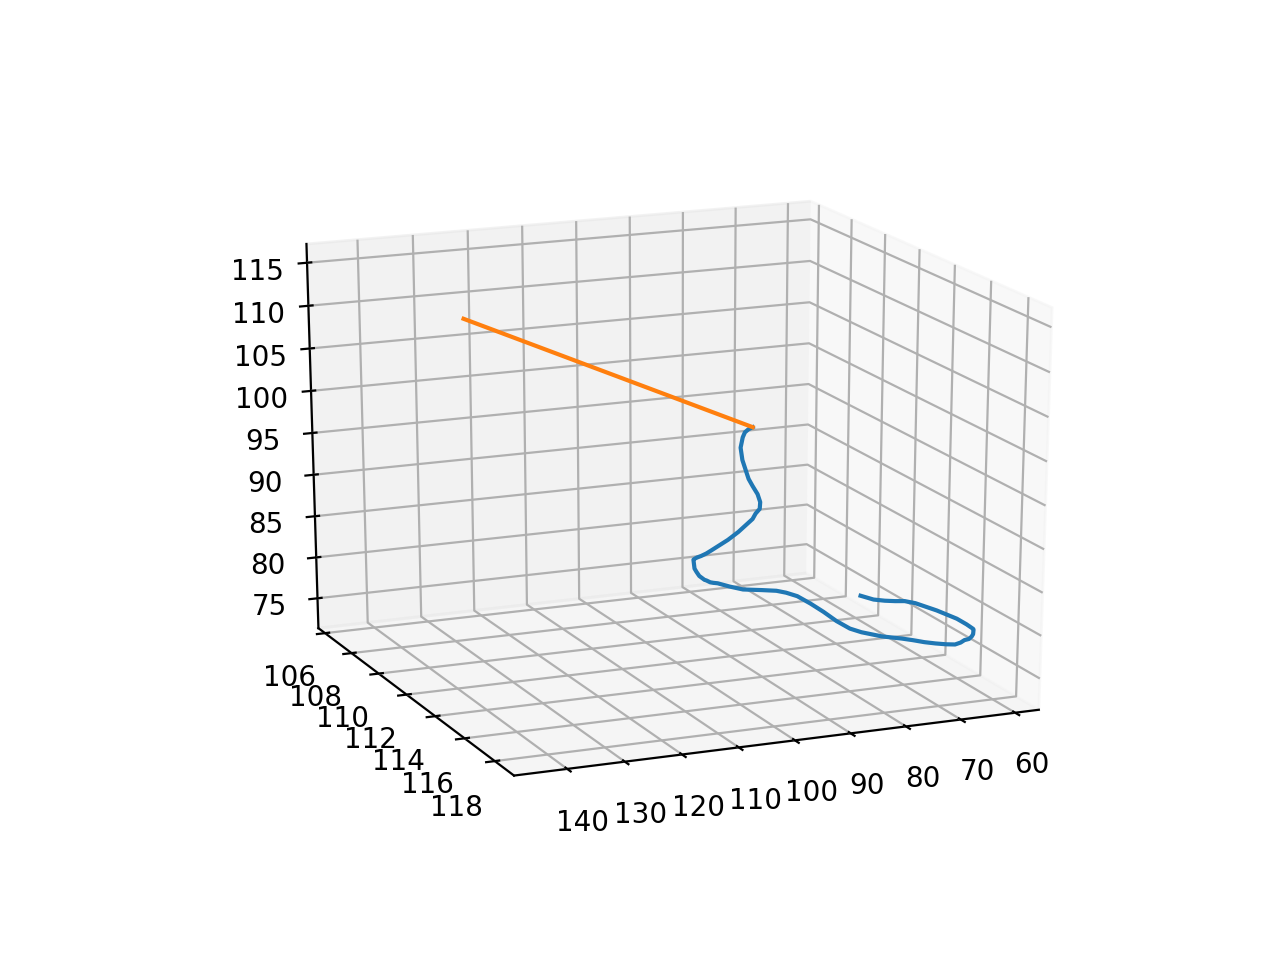

In [116]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])
#print(optimal_steps[:])

In [115]:
states = torch.stack(all_states)
print(states.T[0][:3])

tensor([73.6513, 73.7460, 73.8406], dtype=torch.float64)


In [7]:
all_states = []
for i in range(n_actions):
    state = env.reset(streamline_index=4)
    all_states.append(state.getCoordinate())
    state, _, _, _ = env.step(i)
    all_states.append(state.getCoordinate())

In [40]:
#state = env.reset(streamline_index=4)
#all_states = []
#all_states.append(state.getCoordinate())
action, distance = get_best_action(state, env)
state, reward, _, _ = env.step(action)
print(action, distance, reward)
all_states.append(state.getCoordinate())

Action: 0, Distance: 0.7008397255195292
Action: 1, Distance: 0.7559681912599261
Action: 2, Distance: 0.8391526280446608
Action: 3, Distance: 0.8328600182766539
Action: 4, Distance: 0.7553669268642486
Action: 5, Distance: 0.7812889858110996
Action: 6, Distance: 0.7835393779504325
Action: 7, Distance: 0.8087858906117151
Action: 8, Distance: 0.712966487663421
Action: 9, Distance: 0.6960027931333617
Action: 10, Distance: 0.7658049824341049
Action: 11, Distance: 0.7617178628606608
Action: 12, Distance: 0.8182711688555406
Action: 13, Distance: 0.7193053302674034
Action: 14, Distance: 0.7594775466722203
Action: 15, Distance: 0.753803578127503
Action: 16, Distance: 0.8189334002709188
Action: 17, Distance: 0.829996745600674
Action: 18, Distance: 0.675200144025479
Action: 19, Distance: 0.7614736669828197
18 tensor(0.6752, dtype=torch.float64) 0.0


In [28]:
for state in env.state_history:
    print(state.getCoordinate())
#last_direction = env.state_history[-1].getCoordinate() - env.state_history[-2] .getCoordinate()

tensor([43.4998, 94.5377, 24.2661])
tensor([43.4545, 94.5505, 24.3543], dtype=torch.float64)
tensor([43.4092, 94.5633, 24.4425], dtype=torch.float64)


In [46]:
print(env.points_visited)

2


In [14]:
len(all_states)

201

In [72]:
print(referenceLine[86])

tensor([ 71.7731, 113.9662,  79.6186])


In [70]:
env.reset()
print(env.state.getCoordinate().numpy(), referenceLine[0])
step = 0
#all_rewards = []
eps_reward = 0
for i in optimal_steps:
    next_state, distance, terminal = env.step(i)
    if distance < 0.71:
        reward = 1 - distance
        #print(reward)
        if reward < 0.3:
            reward = 1
    eps_reward += reward
    #all_rewards.append(reward)
    step += 1
print(eps_reward)

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])
tensor(66.2049, dtype=torch.float64)


In [ ]:
for i in range(n_actions):
    
    next_state, distance, terminal = env.step(i)
    

In [8]:
env.reset()
terminal = False
step = 0
actions = []
past_state = env.state
step = 1
while terminal != True:
    for i in range(n_actions)
    action = np.random.randint(n_actions)
    next_state, reward, terminal = env.step(action)
    if reward < 1:
        actions.append(action)
        past_state = next_state
        print("Action: ", action, "Step: ",step, "Coordinates: ", next_state.getCoordinate().numpy(), referenceLine[step].numpy())
        step += 1
    else:
        env.state = past_state
        env.stepCounter = step
    #action = np.random.choice(possible_actions[step])
    #next_state, reward, terminal = env.step(action)
    #step += 1

print(actions)

Action:  100 Step:  1 Coordinates:  [ 73.651344 107.88106   93.29415 ] [ 74.42344 107.87124  93.08491]
Action:  67 Step:  2 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.16057  107.88882   92.774536]
Action:  100 Step:  3 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.78847 107.96255  92.28433]
Action:  100 Step:  4 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 76.45265  108.118454  91.86654 ]
Action:  100 Step:  5 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.116844 108.27435   91.448746]
Action:  100 Step:  6 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.739716 108.54131   91.02359 ]
Action:  100 Step:  7 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.36259  108.80828   90.598434]
Action:  100 Step:  8 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.996666 109.15176   90.25207 ]
Action:  100 Step:  9 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 79.630745 109.495224  89.9057  ]
Actio

KeyboardInterrupt: 

In [16]:
print(referenceLine[6])
print(referenceLine[7])

tensor([ 77.7397, 108.5413,  91.0236])
tensor([ 78.3626, 108.8083,  90.5984])


In [11]:
state = TractographyState(torch.Tensor([ 77.8994346, 108.7020324, 90.72022516]), env.interpolateDWIatState)
for i in range(n_actions):
    env.state = state
    env.stepCounter -= 1
    next_state, _, terminal = env.step(i)
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.min(torch.sum((referenceLine[7] - qry_pt)**2, dim=1))
    if distance < 0.3:
        print(i, next_state.getCoordinate().numpy(), referenceLine[7].numpy(), distance.numpy())

tensor([ 78.1077, 108.7354,  91.6977], dtype=torch.float64)
tensor([ 77.7615, 108.8643,  91.6973], dtype=torch.float64)
tensor([ 77.8808, 108.4698,  91.6927], dtype=torch.float64)
tensor([ 78.0768, 109.0850,  91.6268], dtype=torch.float64)
tensor([ 77.5148, 108.5987,  91.6375], dtype=torch.float64)
tensor([ 78.3125, 108.4477,  91.5947], dtype=torch.float64)
tensor([ 77.7489, 109.2253,  91.5590], dtype=torch.float64)
tensor([ 77.6419, 108.2420,  91.5700], dtype=torch.float64)
tensor([ 78.4297, 108.8083,  91.5614], dtype=torch.float64)
tensor([ 77.4379, 108.9717,  91.5654], dtype=torch.float64)
tensor([ 78.0813, 108.1849,  91.5566], dtype=torch.float64)
tensor([ 78.1025, 109.3932,  91.4139], dtype=torch.float64)
tensor([ 77.3094, 108.3452,  91.4445], dtype=torch.float64)
tensor([ 78.6147, 108.4838,  91.3841], dtype=torch.float64)
tensor([ 77.4417, 109.2998,  91.3783], dtype=torch.float64)
tensor([ 77.8415, 107.9787,  91.4083], dtype=torch.float64)
tensor([ 78.3907, 109.1557,  91.4638], d

In [9]:
env.reset()
next_state, reward, terminal = env.step(100)
print(next_state.getCoordinate().numpy())
print(reward)
print(terminal)

tensor(187.0214)
[ 73.651344 107.88106   93.29415 ]
-1
True


In [49]:
print(possible_actions)

[[47, 75, 80, 88, 93, 96], [67, 75, 80, 88, 93], [62, 67, 75, 80], [62, 67, 75, 80, 83], [62, 67, 75, 80, 83], [62, 67, 75, 83, 96], [62, 67, 75, 83, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 70, 75, 83, 91, 96], [62, 70, 75, 78, 83, 91], [54, 57, 62, 67, 70, 75, 83], [54, 62, 67, 75], [54, 59, 67, 72], [51, 54, 59, 62, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 56, 59, 64], [51, 56, 59, 64], [51, 56, 59, 64], [50, 51, 53, 56, 59], [50, 51, 53, 56, 61, 66], [53, 58, 61, 66, 74, 79], [58, 66, 71, 74, 79], [58, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79, 84], [58, 63, 71, 79, 84, 92], [58, 63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [38, 71, 79, 84, 92], [38, 63, 71, 84, 92, 97], [38, 71, 84, 92, 97], [38, 84, 92, 97], [38, 76, 84, 92, 97], [38, 76, 

In [8]:
env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
print(env.state.getCoordinate())
print(referenceLine[86])
print(possible_actions[85])
for i in possible_actions[85]:
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    env.stepCounter = 84
    next_state, reward, _ = env.step(z)
    print(next_state.getCoordinate(), reward)

tensor([ 71.5173, 114.6476,  79.9506])
tensor([ 71.7731, 113.9662,  79.6186])
[64, 69, 77, 85, 90, 98]
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)


In [76]:
#env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
for i in range(n_actions):
    env.reset()
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    distance = env.rewardForTerminalState(next_state)
    if distance < 0.3:
        print(referenceLine[86].numpy(), next_state.getCoordinate().numpy(), distance.item())

[ 71.773056 113.966225  79.618576] [ 72.30127204 114.02878755  79.99932066] 0.27901215525974304
[ 71.773056 113.966225  79.618576] [ 71.7609279  113.6971063   80.14330044] 0.2753356828217112
[ 71.773056 113.966225  79.618576] [ 71.37937604 113.65758474  79.97858924] 0.15498393104601757
[ 71.773056 113.966225  79.618576] [ 71.66780472 114.12438903  79.11184227] 0.2567791198339029
[ 71.773056 113.966225  79.618576] [ 71.97880832 114.37794723  79.10548775] 0.26325960220840583
[ 71.773056 113.966225  79.618576] [ 71.31423388 113.95652005  79.25698482] 0.2105177635246191
[ 71.773056 113.966225  79.618576] [ 71.97504289 114.04982978  79.29253904] 0.10630013104166292
[ 71.773056 113.966225  79.618576] [ 71.63016002 113.84417747  79.3660627 ] 0.06376299386222199
[ 71.773056 113.966225  79.618576] [ 72.24376411 114.29266559  79.36222956] 0.2215660937612901
[ 71.773056 113.966225  79.618576] [ 71.91375289 113.81268975  79.56895814] 0.023572970787664616
[ 71.773056 113.966225  79.618576] [ 71.351

In [67]:
distance = env.rewardForTerminalState(next_state)
print(referenceLine[86])
print(distance)

tensor([ 71.7731, 113.9662,  79.6186])
tensor(122.0777, dtype=torch.float64)


In [26]:
for i in range(n_actions):
    env.state = TractographyState(torch.FloatTensor([ 74.64776812, 107.9270337, 93.22325858]), env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    env.stepCounter = 2
    if reward < 0.1:
        reward = 1
    elif reward < 0.5:
        reward = 0
    else:
        reward = -1
    if reward == 1:
        #best_actions.append(i)
        print("[{}]".format(i), referenceLine[2].numpy(), next_state.getCoordinate().numpy(), reward)
#print(best_actions)

In [ ]:
state = TractographyState(torch.FloatTensor(referenceLine[0]), env.interpolateDWIatState)
coordinates = state.getCoordinate()

In [ ]:
print(referenceLine[0])

In [ ]:
print(referenceLine[0])
print(referenceLine[70])

In [ ]:
state = TractographyState(referenceLine[69], env.interpolateDWIatState)

In [ ]:
shape = env.reset().getValue().reshape(-1).shape[0]
print(shape)

In [ ]:
state = torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)

In [ ]:
q_vals = agent.main_dqn(state)

In [ ]:
print(state.getValue().shape)
shape = state.getValue().shape
shape = np.prod(np.array(shape))
print(shape)

In [ ]:
state = TractographyState(referenceLine[70], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance_terminal = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )

#print(distance)
#print(distance_terminal)
reward = (torch.tanh(-distance+5.3) + 2*torch.tanh(-distance_terminal+5.3))/2
print(reward)

print(torch.tanh(-distance+5.3))
print(torch.tanh(-distance_terminal+5.3))

reward += 200/20 * reward.sign()
print(reward)

In [ ]:
print(torch.tanh(-distance_terminal+5.3)+2)

In [ ]:
state = TractographyState([32., 84., 94.], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
print(torch.tanh(-distance+5.3))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(-distance)
print(torch.tanh(-distance)+2)
#print(torch.where(distance < env.maxL2dist_to_terminalState, 1, 0 ))

In [ ]:
print(-1.5 + 5)

In [ ]:
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(round(-distance.item(),4))

In [ ]:
print("Init agent")
#memory = ReplayMemory(size=replay_memory_size)
state = env.reset()
agent = Agent(n_actions=n_actions, inp_size=state.getValue().shape, device=device, hidden=256, agent_history_length=agent_history_length, memory_size=replay_memory_size, learning_rate=learning_rate)

print("Init epsilon-greedy action scheduler")
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=100000, replay_memory_start_size=replay_memory_size, model=agent.main_dqn)

step_counter = 0
    
eps_rewards = []

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0

######## fill memory begins here
    while epoch_step < evaluate_every:  # To Do implement evaluation
        state = env.reset()
        episode_reward_sum = 0
        
        #fill replay memory while interacting with env
        for episode_counter in range(max_episode_length):
            # get action with epsilon-greedy strategy       
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0))
                    
            next_state, reward, terminal = env.step(action)

            if reward >= 1:
                reward = 10
            elif reward > -0.05:
                reward = 1
            
            if episode_counter == max_episode_length-1:
                reward = -100
                terminal = True
            # increase counter
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                state=state.getValue(),
                                reward=reward,
                                new_state=next_state.getValue(),
                                terminal=terminal)


            state = next_state

        

            ####### optimization is happening here
            if step_counter > replay_memory_size:
                loss = agent.optimize()


            ####### target network update
            if step_counter > replay_memory_size and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if episode ended before maximum step
            if terminal:
                terminal = False
                state = env.reset()
                break
                
        eps_rewards.append(episode_reward_sum)
        
        if len(eps_rewards) % 10 == 0:
            with open(path+'/logs/rewards.dat', 'a') as reward_file:
                print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])) )
    torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))
########## evaluation starting here
    eval_rewards = []
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        eval_episode_reward = 0
        while eval_steps < max_episode_length:
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0), evaluation=True)

            next_state, reward, terminal = env.step(action)

            eval_steps += 1
            eval_episode_reward += reward
            state = next_state

            if terminal:
                terminal = False
                break

        eval_rewards.append(eval_episode_reward)
    
    print("Evaluation score:", np.mean(eval_rewards))

In [ ]:
#!mkdir -p 'checkpoints/'
#torch.save(agent.main_dqn.state_dict(), 'checkpoints/fiber_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(rewards[-100:])))